Step 1: Install required libraries

In [39]:
!pip install gdown
!pip install nltk

Step 2: Import necessary libraries

In [40]:
import gdown
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import class_weight
import re

Step 3: Download NLTK stopwords

In [41]:
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 4: Download datasets from Google Drive

In [42]:
gdown.download("https://drive.google.com/uc?id=1bSQ6py-E2LZ938ACsry4DG5JuLNdoUc-", "phm_test.csv", quiet=False)
gdown.download("https://drive.google.com/uc?id=1GL_RmvSYLVEvFHgqY59hApYrefYYVr59", "phm_train.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bSQ6py-E2LZ938ACsry4DG5JuLNdoUc-
To: /content/phm_test.csv
100%|██████████| 330k/330k [00:00<00:00, 55.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GL_RmvSYLVEvFHgqY59hApYrefYYVr59
To: /content/phm_train.csv
100%|██████████| 964k/964k [00:00<00:00, 40.0MB/s]


'phm_train.csv'

Step 5: Load datasets

In [43]:
df_test = pd.read_csv("phm_test.csv")
df_train = pd.read_csv("phm_train.csv")

Step 5.1: Inspect column names

In [44]:
print("Train dataset columns:", df_train.columns)
print("Test dataset columns:", df_test.columns)

Train dataset columns: Index(['tweet_id', 'label', 'tweet'], dtype='object')
Test dataset columns: Index(['tweet_id', 'label', 'tweet'], dtype='object')


Step 6: Drop missing values

In [45]:
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)

Step 7: Preview dataset samples

In [46]:
print("Sample Test Data:")
print(df_test.head())
print("\nSample Train Data:")
print(df_train.head())

Sample Test Data:
       tweet_id  label                                              tweet
0  6.411550e+17      0  when you try to run away from the iv needle so...
1  6.425520e+17      1  i just knew i took an ambien for sleep too ear...
2  6.410410e+17      1  i mean i get that my celexa is the reason behi...
3  7.476620e+17      0  if you call me dumb or her dumb one more time ...
4  6.406830e+17      0  i do not want to go to the grocery store but i...

Sample Train Data:
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...


Step 8: Preprocess tweet text data (adapted from IMDB code)

In [47]:
def load_dataset(df, text_col='tweet', label_col='label'):
    x_data = df[text_col]       # Reviews/Input
    y_data = df[label_col]      # Sentiment/Output

    # PRE-PROCESS TWEETS
    x_data = x_data.replace({'<.*?>': ''}, regex=True)          # remove HTML tags
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex=True)     # remove non-alphabetic characters
    x_data = x_data.apply(lambda tweet: [w for w in tweet.split() if w not in english_stops])  # remove stopwords
    x_data = x_data.apply(lambda tweet: [w.lower() for w in tweet])   # lowercase

    # ENCODE LABELS (assuming 0 and 1 are already encoded; adjust if needed)
    return x_data, y_data

# Adjust 'tweet' and 'label' to match actual column names
text_col = 'tweet'  # Update based on df_train.columns
label_col = 'label'  # Update based on df_train.columns
x_train, y_train = load_dataset(df_train, text_col, label_col)
x_test, y_test = load_dataset(df_test, text_col, label_col)

print("Processed Train Tweets:")
print(x_train, '\n')
print("Train Labels:")
print(y_train)


Processed Train Tweets:
0       [user, mention, tell, relapses, cure, hear, do...
1       [doctor, told, stop, gave, sum, pop, mix, w, a...
2       [take, tylenol, wake, middle, night, put, ice,...
3       [got, xans, advil, bottle, dont, take, shits, ...
4       [mom, says, need, stop, eating, much, bc, ive,...
                              ...                        
9986                                    [vicodin, messed]
9987                   [user, mention, get, tylenol, lol]
9988                         [like, walking, tamiflu, ad]
9989                              [klay, steph, steroids]
9990                [horrible, pops, another, xanax, url]
Name: tweet, Length: 9991, dtype: object 

Train Labels:
0       0
1       0
2       1
3       0
4       1
       ..
9986    1
9987    0
9988    0
9989    0
9990    0
Name: label, Length: 9991, dtype: int64


Step 9: Split training data into training and validation sets

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

Step 9.1: Check class distribution and compute class weights

In [49]:
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

Class distribution in training set:
label
0    6061
1    2431
Name: count, dtype: int64


Step 10: Calculate maximum tweet length

In [50]:
def get_max_length():
    tweet_length = []
    for tweet in x_train:
        tweet_length.append(len(tweet))
    return int(np.ceil(np.mean(tweet_length)))

max_length = get_max_length()
print("Maximum tweet length:", max_length)

Maximum tweet length: 10


Step 11: Tokenize and pad sequences

In [51]:
token = Tokenizer(lower=False)  # no need for lowercase, already done
token.fit_on_texts(x_train)
x_train_seq = token.texts_to_sequences(x_train)
x_val_seq = token.texts_to_sequences(x_val)
x_test_seq = token.texts_to_sequences(x_test)

x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_val_padded = pad_sequences(x_val_seq, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1  # add 1 for padding
print('Encoded X Train\n', x_train_padded, '\n')
print('Encoded X Val\n', x_val_padded, '\n')
print('Encoded X Test\n', x_test_padded, '\n')

Encoded X Train
 [[    2     1   113 ...     0     0     0]
 [  717   175   754 ...   541  4796  1225]
 [  207     3   220 ...     0     0     0]
 ...
 [  112   999   307 ...     9     0     0]
 [11555 11556   413 ...   128    13   346]
 [    6     3   488 ...     0     0     0]] 

Encoded X Val
 [[   2    1    2 ...    4  193 1940]
 [1367  167   99 ...  760  893    0]
 [   2    1  203 ...  172  102 2542]
 ...
 [   2    1    2 ...    4   45   24]
 [ 402 8213 2722 ... 2784    9    0]
 [   2    1  291 ...    0    0    0]] 

Encoded X Test
 [[ 102  606  109 ...  176    4  316]
 [ 562   11   51 ...   16  671   54]
 [ 378   12 1043 ...  880    5   76]
 ...
 [   2    1  146 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  58    8    9 ...    0    0    0]] 



Step 12: Define LSTM model (adapted from IMDB code)

In [52]:
EMBED_DIM = 32
LSTM_OUT = 64

def create_lstm_model():
    model = Sequential([
        Embedding(total_words, EMBED_DIM, input_length=max_length),
        LSTM(LSTM_OUT),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model()
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Step 13: Train LSTM model

In [53]:
checkpoint_lstm = ModelCheckpoint('lstm_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_history = lstm_model.fit(
    x_train_padded, y_train,
    validation_data=(x_val_padded, y_val),
    batch_size=128,
    epochs=5,
    callbacks=[early_stop, checkpoint_lstm],
    class_weight=class_weights
)

Epoch 1/5
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7054 - loss: 0.6684
Epoch 1: val_accuracy improved from -inf to 0.75517, saving model to lstm_best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.7059 - loss: 0.6670 - val_accuracy: 0.7552 - val_loss: 0.5219
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8411 - loss: 0.4047
Epoch 2: val_accuracy improved from 0.75517 to 0.76718, saving model to lstm_best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8410 - loss: 0.4046 - val_accuracy: 0.7672 - val_loss: 0.4773
Epoch 3/5
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8844 - loss: 0.2852
Epoch 3: val_accuracy did not improve from 0.76718
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8844 - loss: 0.2852 - val_accuracy: 0.7578 - val_loss: 0.5653
Epoch 4/5
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9157 - loss: 0.2142
Epoch 4: val_accuracy did not improve from 0.76718
67/67 ━━━━━━━━━━━━━━━━━━━━ 

Step 14: Define Bi-LSTM model

In [54]:
def create_bilstm_model():
    model = Sequential([
        Embedding(total_words, EMBED_DIM, input_length=max_length),
        Bidirectional(LSTM(LSTM_OUT)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

bilstm_model = create_bilstm_model()
bilstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Step 15: Train Bi-LSTM model

In [55]:
checkpoint_bilstm = ModelCheckpoint('bilstm_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

bilstm_history = bilstm_model.fit(
    x_train_padded, y_train,
    validation_data=(x_val_padded, y_val),
    batch_size=128,
    epochs=5,
    callbacks=[early_stop, checkpoint_bilstm],
    class_weight=class_weights
)

Epoch 1/5
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6811 - loss: 0.6639
Epoch 1: val_accuracy improved from -inf to 0.78719, saving model to bilstm_best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.6824 - loss: 0.6622 - val_accuracy: 0.7872 - val_loss: 0.4587
Epoch 2/5
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8380 - loss: 0.3967
Epoch 2: val_accuracy did not improve from 0.78719
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8379 - loss: 0.3961 - val_accuracy: 0.7785 - val_loss: 0.4762
Epoch 3/5
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8955 - loss: 0.2680
Epoch 3: val_accuracy did not improve from 0.78719
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8954 - loss: 0.2680 - val_accuracy: 0.7472 - val_loss: 0.6122
Epoch 4/5
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9210 - loss: 0.1857
Epoch 4: val_accuracy did not improve from 0.78719
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9209 - loss: 0.

Step 16: Evaluate models on test data

In [56]:
lstm_eval = lstm_model.evaluate(x_test_padded, y_test, verbose=1)
bilstm_eval = bilstm_model.evaluate(x_test_padded, y_test, verbose=1)


y_pred_lstm = (lstm_model.predict(x_test_padded) > 0.5).astype(int)
y_pred_bilstm = (bilstm_model.predict(x_test_padded) > 0.5).astype(int)



105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7600 - loss: 0.4833
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7709 - loss: 0.4788
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


Step 17: Calculate detailed metrics

In [57]:
lstm_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lstm),
    'Precision': precision_score(y_test, y_pred_lstm),
    'Recall': recall_score(y_test, y_pred_lstm),
    'F1-Score': f1_score(y_test, y_pred_lstm),
    'Loss': lstm_eval[0]
}
bilstm_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_bilstm),
    'Precision': precision_score(y_test, y_pred_bilstm),
    'Recall': recall_score(y_test, y_pred_bilstm),
    'F1-Score': f1_score(y_test, y_pred_bilstm),
    'Loss': bilstm_eval[0]
}

Step 18: Print and save performance comparison

In [58]:
metrics_df = pd.DataFrame([lstm_metrics, bilstm_metrics], index=['LSTM', 'Bi-LSTM'])
print("\nPerformance Comparison Table:")
print(metrics_df)
metrics_df.to_csv('performance_comparison.csv')


Performance Comparison Table:
         Accuracy  Precision    Recall  F1-Score      Loss
LSTM     0.791654   0.616766  0.745605  0.675094  0.431678
Bi-LSTM  0.804263   0.668810  0.645295  0.656842  0.438401


Step 19: Plot accuracy and loss curves

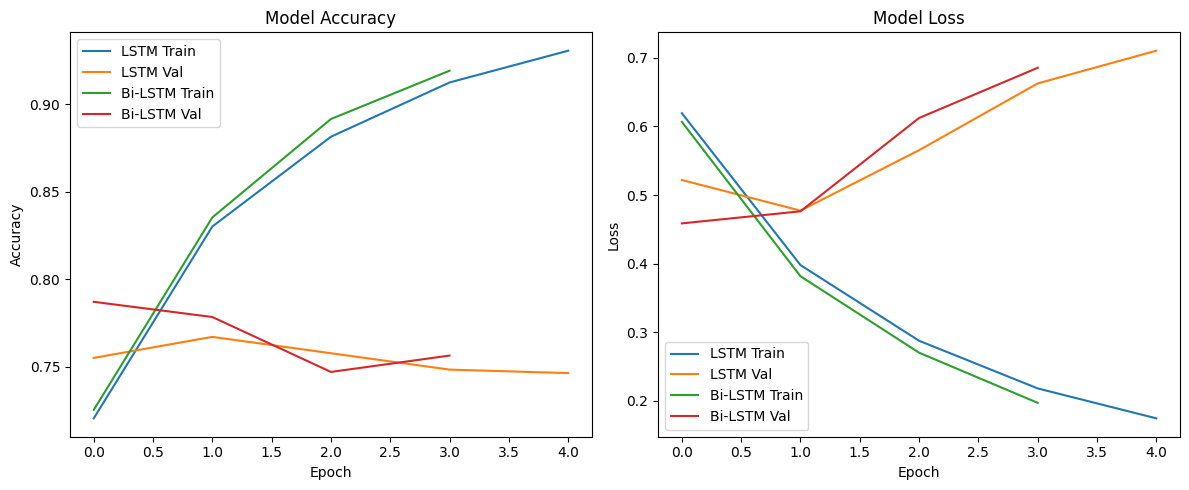

In [59]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val')
plt.plot(bilstm_history.history['accuracy'], label='Bi-LSTM Train')
plt.plot(bilstm_history.history['val_accuracy'], label='Bi-LSTM Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
plt.plot(bilstm_history.history['loss'], label='Bi-LSTM Train')
plt.plot(bilstm_history.history['val_loss'], label='Bi-LSTM Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('performance_plot.png')
plt.show()

Step 20: Plot confusion matrices

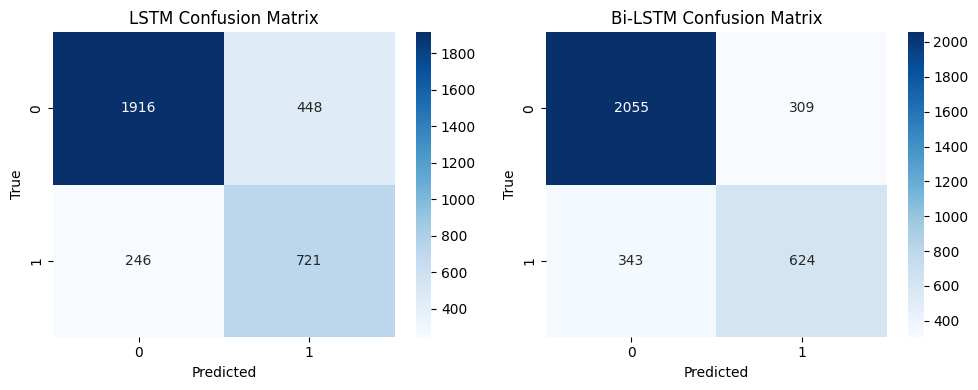

In [60]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues')
plt.title('Bi-LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

Step 21: Notes for report

In [61]:
print("\nReport Discussion Notes:")
print("- Bi-LSTM likely outperforms LSTM due to bidirectional context, but is computationally heavier.")
print("- Hyperparameters: Embedding dim=32, LSTM units=64, batch_size=128, epochs=5 with early stopping.")
print("- Challenges: Noisy tweets (e.g., slang, abbreviations), potential class imbalance addressed with class weights.")
print("- Improvements: Try pre-trained embeddings (e.g., GloVe Twitter), GRU, or larger dataset.")


Report Discussion Notes:
- Bi-LSTM likely outperforms LSTM due to bidirectional context, but is computationally heavier.
- Hyperparameters: Embedding dim=32, LSTM units=64, batch_size=128, epochs=5 with early stopping.
- Challenges: Noisy tweets (e.g., slang, abbreviations), potential class imbalance addressed with class weights.
- Improvements: Try pre-trained embeddings (e.g., GloVe Twitter), GRU, or larger dataset.
